<a href="https://colab.research.google.com/github/hyeonji-cho/Pytorch_Textbook/blob/main/ch6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.1.1 LeNet



### 필요한 라이브러리 호출

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms  # 이미지 변환 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim  # 경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os  # 파일 경로에 대한 함수들을 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm  # 진행 상황을 가시적으로 표현. 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 파이토치는 GPU를 자동으로 할당해 주지 않기 때문에 GPU 할당을 모델과 데이터에 선언해 주어야 한다

AttributeError: partially initialized module 'jax' has no attribute 'tree_util' (most likely due to a circular import)

### 데이터 불러오기

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap06/data/dogs-vs-cats.zip 데이터 불러오기

In [ ]:
!unzip dogs-vs-cats.zip -d dogs-vs-cats/  #dogs-vs-cats 폴더 만들어 압축 풀기

Archive:  dogs-vs-cats.zip
replace dogs-vs-cats/Cat/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 이미지 데이터셋 전처리

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([  # 이미지를 변형할 수 있는 방식들의 묶음
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # 임의의 크기(50~100%)만큼 면적을 무작위로 자르겠다
                transforms.RandomHorizontalFlip(),  # 이미지를 수평 반전
                transforms.ToTensor(),  # 픽셀 값의 범위는 [0.0, 1.0] 사이이고 차원이 (채널수x높이x너비)로 바뀐다
                transforms.Normalize(mean, std)  # 채널별 평균과 표준편차에 맞는 정규화
            ]),
            'val': transforms.Compose([
                transforms.Resize(256), # 이미지 크기 256x256으로 조정
                transforms.CenterCrop(resize), # 이미지의 중앙을 기준으로 resize*resize 크기로 자름
                transforms.ToTensor(), # 이미지를 텐서로 변환
                transforms.Normalize(mean, std) # 이미지 정규화
            ])
        }

    def __call__(self, img, phase):  # 클래스를 호출할 수 있도록 하는 메서드
        return self.data_transform[phase](img)  # 클래스 객체 자체를 호출하면 리턴값이 반환된다

### 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트로 분리

In [ ]:
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]) # cat_directory에 있는 파일명과 경로를 합쳐 반환한다
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]  # 개와 고양이 이미지들을 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)  # 계속 동일한 난수 생성
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]  # 훈련용 400개 이미지
val_images_filepaths = correct_images_filepaths[400:-10]  # 검증용 92개 이미지
test_images_filepaths = correct_images_filepaths[-10:]  # 테스트용 10개 이미지
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

### 테스트 데이터셋 이미지 확인 함수

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):  # enumerate : 인덱스와 값을 리턴
        image = cv2.imread(image_filepath)  # 이미지 파일을 읽을 때 사용
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지의 색상 변경 (입력이미지, BGR->RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]  # 경로명 정규화, /를 기준으로 분할하고 뒤에서 2번쨰 반환
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)  # ravel: 1차원으로 평탄화된 배열을 반환, 1차원 배열에서 인덱스 i에 해당하는 서브플롯에 접근
        ax.ravel()[i].set_title(predicted_label, color=color)  # predicted_label을 타이틀로 사용
        ax.ravel()[i].set_axis_off()  # 이미지의 축 제거
    plt.tight_layout()  # 이미지의 여백을 조정
    plt.show()

### 테스트 데이터셋 이미지를 출력

In [ ]:
display_image_grid(test_images_filepaths)

### 이미지 데이터셋 클래스 정의
- 데이터셋 크기가 클 수 있으므로 __init__에서 전체 데이터를 읽어오는 것이 아니라 경로만 저장해 놓고, __getitem__메서드에서 이미지를 읽어 온다
- 이후 데이터로더에서 데이터셋의 데이터를 메모리로 불러오는데, 한꺼번에 전체 데이터를 불러오는 것이 아니라 배치 크기만큼 분할하여 가져온다

In [ ]:
class DogvsCatDataset(Dataset):  # 데이터셋의 전처리
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 경로만 저장
        self.transform = transform  # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개변수를 받아온다
        self.phase = phase  # 'train' 적용

    def __len__(self):  # images_filepaths 데이터셋의 전체 길이를 반환
        return len(self.file_list)

    def __getitem__(self, idx):  # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태가 된다
        img_path = self.file_list[idx]
        img = Image.open(img_path)  # img_path 위치에서 이미지 데이터들을 가져온다
        img_transformed = self.transform(img, self.phase)  # 이미지에 'train'전처리를 적용

        label = img_path.split('/')[-1].split('.')[0]  # '/'제거, '.'제거
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

### 변수 값 정의

In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

### 이미지 데이터셋 정의

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')  # 훈련 이미지에 train_transforms 적용
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')  # 검증 이미지에 test_transforms 적용

index = 0
print(train_dataset.__getitem__(index)[0].size())  # 훈련 데이터의 크기 출력
print(train_dataset.__getitem__(index)[1])  # 훈련 데이터의 레이블 출

### 데이터로더 정의

- 데이터로더는 배치 관리를 담당한다
- 한 번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에 데이터를 그룹으로 쪼개서 조금씩 불러온다

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 데이터셋, 한 번에 메모리로 불러올 데이터 크기, 섞어서
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}  # 훈련과 검증 데이터셋을 합쳐서 표현

batch_iterator = iter(train_dataloader)  # 이터레이터로 변환
inputs, label = next(batch_iterator)  # 다음 요소 반환 (공급될 데이터, 해당하는 레이)
print(inputs.size())
print(label)

### 모델의 네트워크 클래스

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) # (3, 224, 224)->(16, 220, 220)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (16, 110, 110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) # (32, 106, 106)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (32, 53, 53)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) # 데이터를 1차원 형태로 전환
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

### 모델 객체 생성

In [ ]:
model = LeNet().to(device)
print(model)

### torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

### 학습 가능한 파라미터 수 확인


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

### 옵티마이저와 손실 함수 정의

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 파라미터, 가중치를 변경할 때 얼마나 크게 변경할지, 적절한 방향으로 가속화하며 흔들림을 줄여준다
criterion = nn.CrossEntropyLoss()

### 모델의 파라미터와 손실 함수를 CPU에 할당

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

### 모델 학습 함수 정의

In [ ]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):  # epoch만큼 반복
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델 학습
            else:
                model.eval()  # 모델 평가

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):  # dataloader_dict : 훈련 데이터셋
                inputs = inputs.to(device)  # 훈련 데이터셋을 CPU에 할당
                labels = labels.to(device)
                optimizer.zero_grad()  # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):  # train인 경우에만 gradient 계산을 활성화
                    outputs = model(inputs)  # 입력 데이터를 모델에 전달하여 예측을 얻음
                    _, preds = torch.max(outputs, 1)  # 최대값을 갖는 클래스의 인덱스를 찾음
                    loss = criterion(outputs, labels)  # 손실 함수를 이용한 오차 계산

                    if phase == 'train':
                        loss.backward()  # 역전파 수행
                        optimizer.step()  # 옵티마이저를 사용하여 모델의 파라미터 업데이트

                    epoch_loss += loss.item() * inputs.size(0)  # 현재 배치의 손실 * 해당 배치의 크기
                    epoch_corrects += torch.sum(preds == labels.data)  # 현재 배치에서 정확한 예측의 수

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)  # 최종 오차 계산 (오차/데이터셋의 길이)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)  # 최종 정확도 (epoch_corrects/데이터셋의 길이)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:  # 검증 데이터셋에 대한 가장 최적의 정확도를 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

### 모델 학습

In [ ]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

### 모델 테스트를 위한 함수 정의

In [ ]:
import pandas as pd

id_list = []  # 각 이미지에 대한 ID 저장
pred_list = []  # 각 이미지에 대한 모델의 예측값 저장
_id=0
with torch.no_grad():  # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음. 예측만 수행하고 파라미터가 바뀌지 않음
    for test_path in tqdm(test_images_filepaths):  # 테스트 데이터셋 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')  # 테스트 데이터셋 전처리 적용
        img = img.unsqueeze(0)  # 텐서에 차원을 추가
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()  # 텐서의 요소가 (0,1) 범위에 있고 합계가 1, 모든 행에서 두번째 칼럼(각 이미지에 대한 레이블 예측 확률)을 가져온다, 리스트 형태로 반환
        id_list.append(_id)  # 각 이미지의 ID를 리스트에 추가
        pred_list.append(preds[0])  # 각 이미지의 예측된 레이블 확률을 리스트에 추가

res = pd.DataFrame({  # 테스트 데이터셋의 예측 결과인 id와 label을 데이터 프레임에 저장
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)  # id열을 기준으로 정렬, 원본 데이터프레임을 변경하도록 지정
res.reset_index(drop=True, inplace=True)  # 데이터프레임의 인덱스를 재설정, 원본 데이터프레임을 변경하도록 지정

res.to_csv('LesNet.csv', index=False)  # 데이터 프레임을 CSV 파일로 저장

### 테스트 데이터셋의 예측 결과 호출

In [ ]:
res.head(10)  # 데이터프레임에서 10개의 값을 보여준다

### 테스트 데이터셋 이미지를 출력하기 위한 함수 정의

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}  # 개와 고양이에 대한 클래스 정의
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR형식 -> RGB형식

        a = random.choice(res['id'].values)  # 데이터프레임의 id라는 칼럼에서 임의로 데이터를 가져옴
        label = res.loc[res['id'] == a, 'label'].values[0]  # id열이 선택된 ID와 일치하는 행을 선택하고, 이 행에서 label열의 값을 가져온다
        if label > 0.5:  # 레이블 값이 0.5보다 크다면 개
            label = 1
        else:  # 레이블 값이 0.5보다 작으면 고양이
            label = 0
        ax.ravel()[i].imshow(image)  # ax.ravel():다차원 배열을 1차원으로 펴줌
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()  # 서브플롯 간의 간격을 최적화
    plt.show()

### 테스트 데이터셋 예측 결과 이미지 출력

In [ ]:
display_image_grid(test_images_filepaths)

# 6.1.2 AlexNet

### 필요한 라이브러리 호출

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 데이터 전처리

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

### 데이터를 가져와서 훈련, 검증 테스트 용도로 분리

In [ ]:
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


### 커스텀 데이터셋 정의

In [ ]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

### 변수에 대한 값 정의

In [ ]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

### 훈련, 검증, 테스트 데이터셋 정의

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


### 데이터셋을 메모리로 불러옴

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1])


### AlexNet 모델 네트워크 정의

In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### model 객체 생성

In [ ]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 옵티마이저 및 손실 함수 정의

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

### 모델 네트워크 구조 확인

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

### 모델 학습 함수 정의

In [ ]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

### 모델 학습

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-16-8b28962edeb7>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6939 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6944 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6942 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6936 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.4891
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Training complete in 0m 30s


### 모델을 이용한 예측

In [ ]:
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('alexnet.csv', index=False)

<ipython-input-18-ea019e33f897>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

### 데이터 프레임 결과 확인

In [ ]:
res.head(10)

id     label
0  145  0.496548
1  211  0.498008
2  162  0.497326
3  200  0.499889
4  210  0.498561
5  224  0.496455
6  213  0.496679
7  109  0.498781
8   15  0.497254
9  167  0.495924

### 예측 결과를 시각적으로 표현하기 위한 함수 정의

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

### 예측 결과에 대해 이미지와 함께 출력

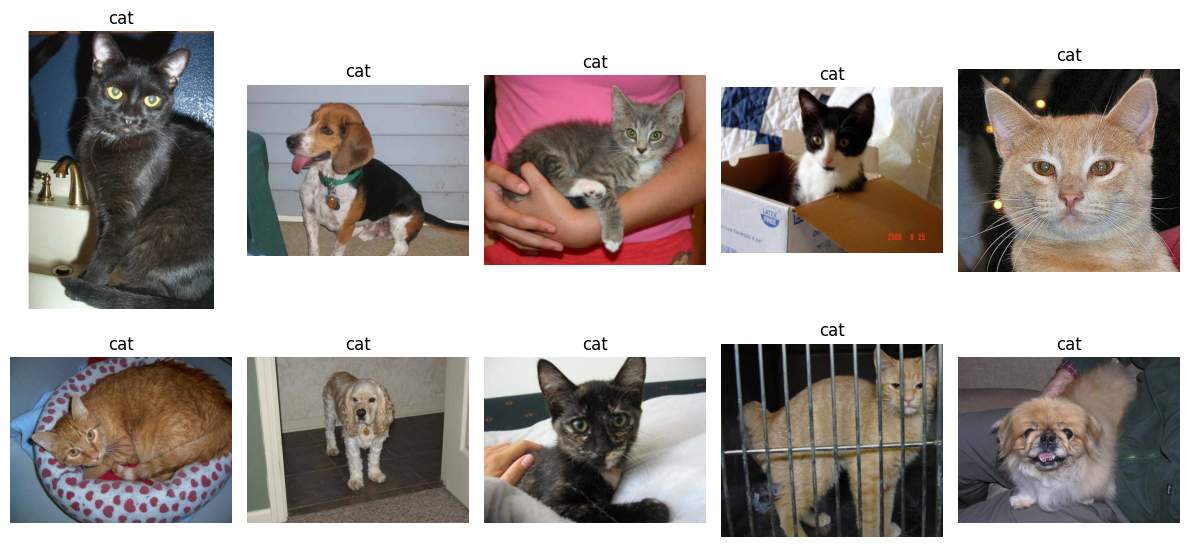

In [ ]:
display_image_grid(test_images_filepaths)

# 6.1.3 VGGNet (VGG11)

### 필요한 라이브러리 호출

In [ ]:
import copy  # 객체 복사
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### VGG 모델 정의

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features   # VGG 모델에 대한 매개변수에서 받아 온 features 값을 self.features에 넣어 준다
        self.avgpool = nn.AdaptiveAvgPool2d(7)  # 입력된 텐서를 7x7 출력 크기로 조정
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )  # 완전연결층과 출력층 정의

    def forward(self, x):
        # 입력 이미지 x를 모델의 feature extractor에 통과시킵니다.
        x = self.features(x)
        # 특성 추출기를 통과한 텐서에 adaptive average pooling을 적용합니다.
        x = self.avgpool(x)
        # 특성 맵을 1차원으로 펼쳐서 fully connected layer에 입력할 준비를 합니다.
        h = x.view(x.shape[0], -1)
        # 펼쳐진 특성 벡터를 분류기에 통과시켜 클래스를 예측합니다.
        x = self.classifier(h)
        # 예측된 클래스 및 특성 벡터를 반환합니다.
        return x, h

### VGG11, VGG13, VGG16, VGG19 모델 유형 정의

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']  # 8(합성곱층)+5(풀링층)

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']  # 10(합성곱층)+5(풀링층)

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']  # 13(합성곱층)+5(풀링층)

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']  # 16(합성곱층)+5(풀링층)

### VGG 계층 정의

In [ ]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:  # vgg11_config 값들을 가져옵니다
        assert c == 'M' or isinstance(c, int)  # c가 'M' 이거나 int라면
        if c == 'M':  # c가 'M'이라면 최대 풀링(MaxPool2d) 적용
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:  # c가 숫자라면 합성곱(Conv2d) 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:  # 배치 정규화를 적용할지에 대한 코드
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]  # 배치 정규화 + ReLU 적용
            else:  # 배치 정규화가 적용되지 않는다면
                layers += [conv2d, nn.ReLU(inplace = True)]  # ReLU 적용
            in_channels = c

    return nn.Sequential(*layers)  # 네트워크의 모든 계층을 반환

### 모델 계층 생성

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

### VGG11 계층 확인

In [ ]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### VGG11 전체에 대한 네트워크
- vgg11_layers와 VGG()에서 정의했던 완전연결층과 출력층이 포함된 구성

In [ ]:
OUTPUT_DIM = 2  # 개와 고양이 두 개의 클래스 사용
model = VGG(vgg11_layers, OUTPUT_DIM).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### VGG11 사전 훈련된 모델 사용

In [ ]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)  # 기본 모델에 배치 정규화가 적용된 모델을 사용, 사전 훈련된 모델을 사용(미리 학습된 파라미터 값들을 사용하겠다)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:09<00:00, 55.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### 이미지 데이터 전처리

In [ ]:
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),  # 256x256 크기로 이미지를 조정
                           transforms.RandomRotation(5),  # 5도 이하로 이미지를 회전
                           transforms.RandomHorizontalFlip(0.5),  # 이미지가 50%의 확률로 수평으로 뒤집힌다
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

### ImageFolder를 이용하여 데이터셋 불러오기

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap06/data/catanddog.zip 데이터 불러오기

Saving catanddog.zip to catanddog.zip


In [ ]:
!unzip catanddog.zip    #압축 풀기
!unzip catanddog.zip -d catanddog/  #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: test/
   creating: test/Cat/
  inflating: test/Cat/8100.jpg       
  inflating: test/Cat/8101.jpg       
  inflating: test/Cat/8102.jpg       
  inflating: test/Cat/8103.jpg       
  inflating: test/Cat/8104.jpg       
  inflating: test/Cat/8105.jpg       
  inflating: test/Cat/8106.jpg       
  inflating: test/Cat/8107.jpg       
  inflating: test/Cat/8108.jpg       
  inflating: test/Cat/8109.jpg       
  inflating: test/Cat/8110.jpg       
  inflating: test/Cat/8111.jpg       
  inflating: test/Cat/8112.jpg       
  inflating: test/Cat/8113.jpg       
  inflating: test/Cat/8114.jpg       
  inflating: test/Cat/8115.jpg       
  inflating: test/Cat/8116.jpg       
  inflating: test/Cat/8117.jpg       
  inflating: test/Cat/8118.jpg       
  inflating: test/Cat/8119.jpg       
  inflating: test/Cat/8120.jpg       
  inflating: test/Cat/8121.jpg       
  inflating: test/Cat/8122.jpg       
  inflating: test/Cat/8123.jpg       
  inflating: test/Cat/

### ImageFolder를 이용하여 데이터셋 불러오기

In [ ]:
train_path = 'catanddog/train'  # 훈련 데이터셋이 위치한 경로
test_path = 'catanddog/test'  # 테스트 데이터셋이 위치한 경로

train_dataset = torchvision.datasets.ImageFolder(  # 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용한다
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

385
98


(None, None)

### 훈련과 검증 데이터 분할

In [ ]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)  # 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples  # 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset,  # 분할에 사용될 데이터셋
                                           [n_train_examples, n_valid_examples])  # 훈련 데이터셋 크기, 검증 데이터셋 크기

### 검증 데이터 전처리

In [ ]:
valid_data = copy.deepcopy(valid_data)  # valid_data의 복사본 생성
valid_data.dataset.transform = test_transforms  # test_transforms 적용

### 훈련, 검증, 테스트 데이터셋 수 확인

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 346
Number of validation examples: 39
Number of testing examples: 98


### 메모리로 데이터 불러오기

In [ ]:
BATCH_SIZE = 32 #메모리 부족으로 오류가 발생하여 배치 사이즈를 줄였습니다
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)  # 훈련 데이터셋은 임의로 섞어서 가져온다

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size = BATCH_SIZE)

### 옵티마이저와 손실 함수 정의

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### 모델 정확도 측정 함수

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)  # 각 샘플에 대해 가장 높은 확률의 클래스를 선택
    correct = top_pred.eq(y.view_as(top_pred)).sum()  # 예측과 정답이 일치하는 것들의 개수를 합산
    acc = correct.float() / y.shape[0]  # 모델이 올바르게 예측한 샘플의 비율
    return acc

### 모델 학습 함수 정의

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 모델 성능 측정 함수

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 학습 시간 측정 함수

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 모델 학습

In [ ]:
import time

EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)  # 훈련 데이터셋을 모델에 적용한 결과를 train_loss와 train_acc에 저장
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)  # 검증 데이터셋을 모델에 적용한 결과를 valid_loss와 valid_acc에 저장

    if valid_loss < best_valid_loss:  # valid_loss가 가장 작은 값을 구하고 그 모델을 VGG-model.pt 이름으로 저장
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)  # 모델 훈련에 대한 시작과 종료 시간을 저장

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.697 | Train Acc: 50.09%
	 Valid. Loss: 0.694 |  Valid. Acc: 39.29%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.704 | Train Acc: 44.21%
	 Valid. Loss: 0.695 |  Valid. Acc: 39.29%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.698 | Train Acc: 51.42%
	 Valid. Loss: 0.696 |  Valid. Acc: 37.72%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.695 | Train Acc: 52.19%
	 Valid. Loss: 0.694 |  Valid. Acc: 46.43%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.683 | Train Acc: 54.33%
	 Valid. Loss: 0.697 |  Valid. Acc: 46.43%


### 테스트 데이터셋을 이용한 모델 성능 측정

In [ ]:
model.load_state_dict(torch.load('VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.688 | Test Acc: 58.59%


### 테스트 데이터셋을 이용한 모델의 예측 확인 함수

In [ ]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)  # 열을 따라 가장 큰 값을 찾는다
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)  # 텐서를 연결할 때 사용한다. 행을 기준
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

### 예측 중에서 정확하게 예측한 것을 추출

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)  # 최댓값을 갖는 인덱스를 반환
corrects = torch.eq(labels, pred_labels)  # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):  # 여러개의 리스트를 합쳐서 새로운 튜플 타입으로 반환
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)  # 데이터를 정렬(내림차순, 예측된 클래스의 확률 분포에서 가장 높은 값)

### 이미지 출력을 위한 전처리

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)  # 주어진 최소, 최대의 범주에 이미지가 위치하도록
    image.add_(-image_min).div_(image_max - image_min + 1e-5)  # 새로운 공간 할당 없이 기존의 메모리에 위치한 값을 대체
    return image

### 모델이 정확하게 예측한 이미지 출력 함수

In [ ]:
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))  # 제곱근 계산
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)  # 출력하려는 그래프 개수만큼 subplot 만든다
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)  # (높이, 너비, 채널)에서 높이->너비, 너비->채널, 채널->높이 로 축 변경
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:  # 본래 이미지대로 출력하기 위해 normalize_image 함수 호출
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

### 예측 결과 이미지 출력

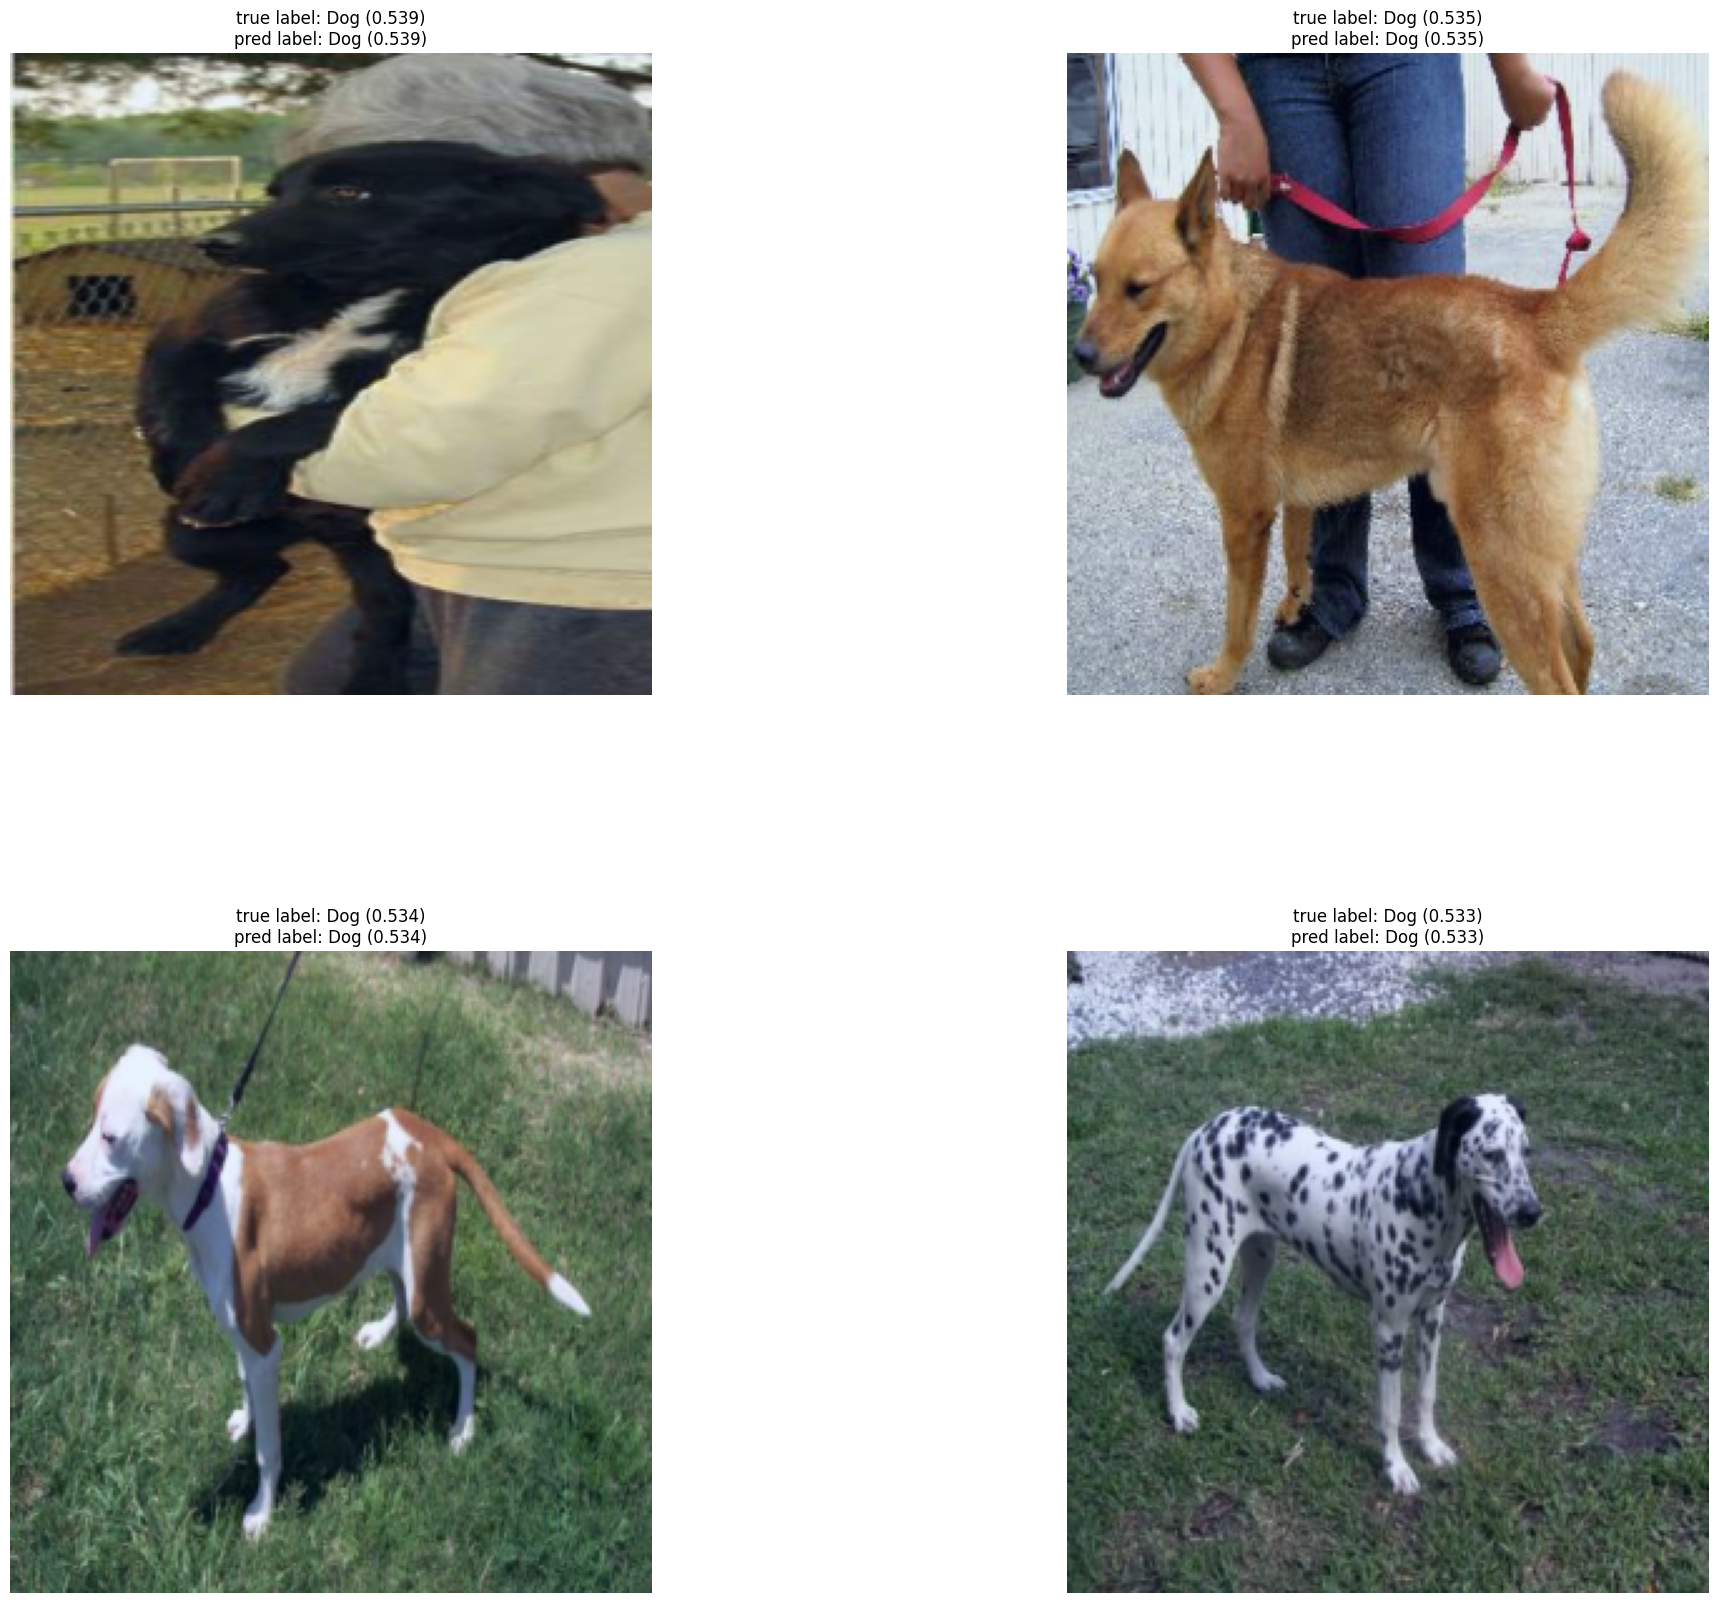

In [ ]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

# 6.1.5 ResNet

### 필요한 라이브러리 호출

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple  # 튜플의 성질을 갖고 있지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있다
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 이미지 데이터 전처리

In [ ]:

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

### 변수에 대한 값 정의

In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

### 훈련과 테스트 데이터셋 불러오기

In [ ]:
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

### 데이터셋을 훈련, 검증, 테스트 용도로 분리

In [ ]:
random.seed(42)
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

### 이미지에 대한 레이블 구분 (개 = '1', 고양이 = '0')

In [ ]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

### 이미지 데이터셋 정의

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

### 데이터셋의 데이터를 메모리로 불러오기
- 불러올 때는 배치 크기만큼 나눠서 불러온다

In [ ]:
train_iterator  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

### 기본 블록 정의
- 합성곱(3x3) 2개로 구성된다

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)  # 3x3 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)  # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:  # 다운샘플이 적용되는 부분.
                        # 입력 데이터의 크기와 네트워크를 통과한 후 출력 데이터의 크기가 다를 경우에 사용한다
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)  # 합성곱층에 스트라이드를 적용한다
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i  # 아이덴티티 매핑 적용. 특정 층에 존재하는 출력 결과를 다음 합성곱층을 통과한 출력 결과에 더해 준다
        x = self.relu(x)

        return x


### 병목 블록 정의
- 기본 블록은 3x3 합성곱층 2개를 갖는다
- 병목 블록은 1x1 합성곱층, 3x3 합성곱층, 1x1 합성곱층의 구조를 갖는다
- 기본 블록을 병목 블록으로 변경하는 이유는 계층을 더 깊게 쌓으면서 계산에 대한 비용을 줄일 수 있기 때문이다
- 계층이 많아진다는 것은 활성화 함수가 더 많이 포함된다는 것이고, 이것은 더 많은 비선형성을 처리할 수 있음을 의미한다
- 다양한 입력 데이터에 대한 처리가 가능하다

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4  # ResNet에서 병목 블록을 정의하기 위한 파라미터

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)  # 1x1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)  # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False) # 1x1 합성곱층. 다음 계층의 입력 채널 수와 일치하도록 self.expansion*out_channels를 함
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

### ResNet 모델 네트워크

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config  # ResNet을 호출할 때 넘겨준 config 값들을 block, n_blocks, channels에 저장
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4 # 블록크기 = 채널크기 = 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [ ]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
pretrained_model = models.resnet50(pretrained = True)

In [ ]:
print(pretrained_model)

In [ ]:
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

In [ ]:
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('ReNet.csv', index=False)
res.head(10)

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)